In [2]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5pyd
import pandas as pd
import windrose as wr
import astral

In [3]:
import rex

In [4]:
from mmctools.helper_functions import theta
from mmctools.helper_functions import T_to_Tv
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_timeheight

In [5]:
# constants
k = 0.4      # von Karman constant
g = 9.81
Rd = 287.05  # gas constant for dry air [J kg^-1 K-1]
Cp = 1004.   # specific heat at constant pressure for dry air [J kg^-1 K-1]

# WIND Toolkit Analysis (updated dataset)
# Part 1 - Read, processing, and initial classification of data

Regis Thedin \
Dec 2020

## 1. Read updated dataset

In [6]:
# TOTW single column coordinates
totw_coord = (42.921494, -105.785106)

# TOTW 30x30km region
totw30x30km_bottomLeftCoord = (42.8297, -105.9565)
totw30x30km_topRightCoord = (43.0826, -105.6611)

# TOTW 20x20km region
totw20x20km_bottomLeftCoord = (42.861257, -105.908994)
totw20x20km_topRightCoord = (43.044721, -105.661957)

In [7]:
# full hdf5 data files
wtk2017hourly = '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/wtk_ERA5_En1_2017.h5'
wtk2018hourly = '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/wtk_ERA5_En1_2018.h5'

wtk2017_5min = ['/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_0m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_2m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_10m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_20m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_40m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_60m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_80m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_100m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_120m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_140m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_160m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_180m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2017/wtk_ERA5_En1_2017_200m.h5']

wtk2018_5min = ['/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_0m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_2m.h5',   \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_10m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_20m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_40m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_60m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_80m.h5',  \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_100m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_120m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_140m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_160m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_180m.h5', \
                '/lustre/eaglefs/shared-projects/MSS/tap/ERA5_En1/WTK/h5/2018/wtk_ERA5_En1_2018_200m.h5']

In [8]:
w2017 = rex.WindX(wtk2017hourly, hsds=False)
w2018 = rex.WindX(wtk2018hourly, hsds=False)

In [9]:
# Get grid IDs of the 20x20 km area around TOTW
totw_gids = w2017.box_gids(totw20x20km_bottomLeftCoord, totw20x20km_topRightCoord)   # len 96

### 1.1. Data fields


In [10]:
fields=w2017.datasets

In [11]:
# Fields (units from `ncdump`)
timeheight_fields = [
    'windspeed',                 # [m/s]
    'winddirection',             # [deg from N]
    'pressure',                  # [Pa]
    'temperature',               # [deg C]
    'turbulent_kinetic_energy',  # [m2/s2]
]

time_fields = [
     'boundary_layer_height',        # [m]
     'friction_velocity_2m',         # [m/s]
     'inversemoninobukhovlength_2m', # [1/m]
     'latent_heat_flux',             # [W/m2]
     'precipitationrate_0m',         # [mm/hour]
     'relativehumidity_2m',          # [%]
     'skin_temperature',             # [deg C]
     'surface_heat_flux',            # [W/m2]
     'surface_sea_temperature',      # [deg C]
]

### 1.2. Initialize dataframes
Keeping two separate dataframes: `dfsc` for single-column data, and `df20km` for average data within a 20x20 km box around the wind farm

In [12]:
# Get unique heights
heights = []
for name in timeheight_fields:
    fullnames = [field for field in fields if field.startswith(name+'_')]
    assert all([fullname.endswith('m') for fullname in fullnames])
    heights += [float(fullname.split('_')[-1][:-1]) for fullname in fullnames]
heights_u = np.unique(heights)

In [13]:
# Initialize dataframes
timeindex = pd.Index(w2017.time_index.union(w2018.time_index))
multicolumns = pd.MultiIndex.from_product((timeheight_fields, heights_u), names=(None,'height'))

dfsc = pd.DataFrame(index=timeindex, columns=multicolumns, dtype=float)
dfsc.index.names = ['datetime']
df20km = pd.DataFrame(index=timeindex, columns=multicolumns, dtype=float)
df20km.index.names = ['datetime']

### 1.3. Add time-height data

In [14]:
# Fill in dataframe based on single-column data
for name in timeheight_fields:
    fullnames = [field for field in fields if field.startswith(name+'_')]
    heights = [float(fullname.split('_')[-1][:-1]) for fullname in fullnames]
    for fullname,height in zip(fullnames,heights):
        # print('Reading',name,height)
        data = pd.concat([w2017.get_lat_lon_df(fullname,totw_coord),w2018.get_lat_lon_df(fullname,totw_coord)])
        dfsc.loc[:,(name,height)] = data.values

In [15]:
# Fill in dataframe based on 20x20 avg data
for name in timeheight_fields:
    fullnames = [field for field in fields if field.startswith(name+'_')]
    heights = [float(fullname.split('_')[-1][:-1]) for fullname in fullnames]
    for fullname,height in zip(fullnames,heights):
        #print('Reading',name,height)
        data = pd.concat([w2017.get_gid_df(fullname,totw_gids).mean(axis=1),w2018.get_gid_df(fullname,totw_gids).mean(axis=1)])
        df20km.loc[:,(name,height)] = data.values
        
        

### 1.4. Add single-height variables
Add the single height variables (from `time_fields`, like $z_i$ and $u*$ to height $z=0$. This is not very space efficient, but it makes computations significantly more convenient.

Also copies both relative humidity and inverse Obukhov length (that are both defined at 2m) to all other heights. Again, not space efficient, but the relative humidity is needed at all heights to compute virtual temperature (and we assume it does not vary with height). The inverse of $L$, on the other hand, is just copied for convenience to make it easier to compute the stability state and use `loc` to get data.

In [16]:
for name in time_fields:
    dfsc[(name,0)] = pd.concat([w2017.get_lat_lon_df(name,totw_coord),w2018.get_lat_lon_df(name,totw_coord)]).values
    df20km[(name,0)] = pd.concat([w2017.get_gid_df(name,totw_gids).mean(axis=1),w2018.get_gid_df(name,totw_gids).mean(axis=1)])

In [17]:
for h in heights_u:
    for var in 'relativehumidity_2m','inversemoninobukhovlength_2m':
        data = pd.concat([w2017.get_lat_lon_df(var,totw_coord),w2018.get_lat_lon_df(var,totw_coord)])
        dfsc[(var,h)] = data.values
        data = pd.concat([w2017.get_gid_df(var,totw_gids).mean(axis=1),w2018.get_gid_df(var,totw_gids).mean(axis=1)])
        df20km[(var,h)] = data.values


## 2. Load old WIND Toolkit data to compare
Old data processed by Eliot and Regis. Adding a few operations here to put both time series and column data dataframes into a single dataframe of equivalent format for plotting alongside new data.

In [18]:
# Load time series and column data from Eliot's a2e-mmc/assissment/datasets/WINDToolkit/{1-*,2_*,3_*}
datadir = '/home/rthedin/a2e-mmc/assessment/datasets/WINDToolkit/data'

tsdata = 'WTK_ts.calc.csv.gz'    # time-series data
columndata = 'WTK.calc.csv.gz'   # time-height data

dfts = pd.read_csv(os.path.join(datadir,tsdata),parse_dates=['datetime'],index_col=0)
dfcd = pd.read_csv(os.path.join(datadir,columndata),parse_dates=['datetime']).set_index(['datetime','height'])

In [19]:
# Get fields
time_fields_oldWTK = list(dfts.columns)
heights_oldWTK = dfcd.index.get_level_values('height').unique()

In [20]:
dfold = dfcd.copy()
dfold = dfold.unstack()

In [21]:
# Add time-series data to column-data data
for name in time_fields_oldWTK:
    dfold[(name,2)] = dfts[name].values
    
# Make a copy of all the quantities at height 2m to height 0m to easier comparison with newer WTK data
for name in list(dfcd.columns) + list(dfts.columns):
    dfold[(name,0)] = dfold[(name,2)].values

## 3. Get weather station data using Mesonet API

https://developers.synopticdata.com/mesonet/

* get private API key at https://developers.synopticdata.com/
* create token at https://api.synopticdata.com/v2/auth?apikey={your Private API key}

API vars:
https://developers.synopticdata.com/mesonet/v2/api-variables/

Station selection:
https://developers.synopticdata.com/mesonet/v2/station-selectors/

Section written by Eliot, modified/used by Regis

In [22]:
import urllib

In [23]:
datestart = pd.to_datetime('2017-01-01 00:00')
datefinish = pd.to_datetime('2018-12-31 00:00')

varnames = [
    'air_temp','air_temp_2m','air_temp_10m','soil_temp_ir','dew_point_temperature','virtual_temp','relative_humidity',
    'pressure','sea_level_pressure',
    'wind_speed','wind_direction','wind_gust','peak_wind_speed',
    'sonic_wind_speed','sonic_wind_direction','sonic_vertical_vel','sonic_zonal_wind_stdev','sonic_vertical_wind_stdev',
    'sonic_air_temp','sonic_air_temp_stdev',
    'solar_radiation','vertical_heat_flux','friction_velocity',
]

stationlist = ['kcpr']
#lat,lon,radius = 40.99429, -103.52535, 100. # miles

In [24]:
datadir = 'data'
os.makedirs(datadir,exist_ok=True)

figdir = 'figures'
os.makedirs(figdir,exist_ok=True)

url = "http://api.mesowest.net/v2/stations/timeseries"
with open('mesonetToken.txt','r') as f:
    token = f.readline()

### 3.1. Read data

In [25]:
args = {
    'start': datestart.strftime('%Y%m%d%H%M'),
    'end': datefinish.strftime('%Y%m%d%H%M'),
    'obtimezone': 'UTC',
    'vars': ','.join(varnames),
    'units': 'temp|C',
    'token': token,
    'output': 'csv',
}
if len(stationlist) > 0:
    args['stids'] = ','.join(stationlist)
else:
    args['radius'] = f'{lat:f},{lon:f},{radius:g}'

In [26]:
apistring = urllib.parse.urlencode(args)
fullurl = f'{url}?{apistring}'

datapath = os.path.join(datadir,f"rawdata_{datestart.strftime('%Y%m%d')}-{datefinish.strftime('%Y%m%d')}.csv")

#
# UNCOMMENT TO DOWNLOAD DATA
#
# request = urllib.request.urlopen(fullurl)
# rawdata = request.read()
# with open(datapath,'w') as f:
#     f.write(rawdata.decode())

In [27]:
with open(datapath,'r') as f:
    line = f.readline()
    while line.startswith('#'):
        print(line.strip())
        line = f.readline()
    channels = line.strip().split(',')
    units = dict(zip(channels,f.readline().split(',')))
    data = pd.read_csv(f, names=channels, parse_dates=['Date_Time']).set_index(['Date_Time','Station_ID'])

# STATION: KCPR
# STATION NAME: Casper, Natrona County International Airport
# LATITUDE: 42.89750
# LONGITUDE: -106.47306
# ELEVATION [ft]: 5348
# STATE: WY


### 3.2. Check data

In [28]:
dfcasp = data.xs(stationlist[0].upper(),level='Station_ID')
for col,series in dfcasp.iteritems():
    if np.all(pd.isna(series)):
        print(col,'is unavailable')
        
#print(stationlist[0].upper(),'statistics:')
#display(dfcasp.describe())

In [29]:
# Resample data into 1 hour
dfcasp = dfcasp.resample('1h').mean()

# Rename the useful variables for convenience
renameDict = {'air_temp_set_1':'temperature', \
              'relative_humidity_set_1':'RH', \
              'wind_speed_set_1':'windspeed', \
              'wind_direction_set_1':'winddirection', \
              'wind_gust_set_1':'windgust', \
              'peak_wind_speed_set_1':'peakwindspeed'}

dfcasp.rename(columns=renameDict, inplace=True)
dfcasp.index.rename('datetime',inplace=True)

## 4. Perform additional operations

### 4.1. Adjust timezone
WTK data is in UTC and so is airport data. Converting them to MST.

In [30]:
dfold.index = dfold.index.tz_localize('UTC').tz_convert('US/Mountain')
    
for df in dfsc,df20km,dfcasp:
    df.index = df.index.tz_convert('US/Mountain')

### 4.2. Rename and stack dataframes
Make names shorter and consistent for convenience

In [31]:
# Updated datasets
renameDict = {'boundary_layer_height':'z_i', \
              'friction_velocity_2m':'ustar', \
              'inversemoninobukhovlength_2m':'inverseL_2m', \
              'latent_heat_flux':'latent_hfx', \
              'precipitationrate_0m':'precipRate', \
              'relativehumidity_2m':'RH_2m', \
              'skin_temperature':'skinTemp', \
              'surface_heat_flux':'hfx_Wm2', \
              'surface_sea_temperature':'SST', \
              'turbulent_kinetic_energy':'tke', }

dfsc = dfsc.stack(dropna=False)
dfsc.rename(columns=renameDict, inplace=True)

df20km = df20km.stack(dropna=False)
df20km.rename(columns=renameDict, inplace=True)

In [32]:
# Old WTK dataset
renameDict = {'u*':'ustar', \
              'z/L':'zoverL_2m', \
              'precipitationrate':'precipRate', \
              'RH':'RH_2m', \
              'stability_zL':'stability', \
              'hfx':'hfx_Wm2' }

dfold.rename(columns=renameDict, inplace=True)
dfold = dfold.stack(dropna=False)

### 4.3. Interpolate pressure values

In [33]:
for df in dfsc,df20km:
    p = df['pressure'].unstack(level=0).copy()
    p = p.interpolate(method='index', limit=None, limit_area='inside')

    df['pressure'] = p.stack().reorder_levels(['datetime','height']).sort_index()

### 4.4. Calculate additional quantities

In [34]:
for df in dfsc,df20km:
    # Convert deg C to K
    df['temperature'] = df['temperature'] + 273.15
    df['skinTemp'] = df['skinTemp'] + 273.15
    df['SST'] = df['SST'] + 273.15
    
    # potential temperature [K]
    df['theta'] = theta(df['temperature'], df['pressure'], p0=df['pressure'].xs(0,level='height'))
    # virtual potential temperature [K]
    df['thetav'] = T_to_Tv(df['theta'], p=0.01*df['pressure'], RH=df['RH_2m'])

    # density [km/m3]
    tvirtual = T_to_Tv(df['temperature'], p=0.01*df['pressure'], RH=df['RH_2m'])
    df['density'] = df['pressure']/(Rd*tvirtual)

    # Convert heat fluxes from W/m2 to K-m/s
    df['hfx_Kms'] = df['hfx_Wm2'] / (df['density'].xs(2,level='height')*Cp)
    df['latent_hfx'] = df['latent_hfx'] / (df['density'].xs(2,level='height')*Cp)

    # Add cardinal direction as a field for easy access
    winddir_ranges = np.hstack((0,np.arange(11.25,360,(360/16)),360))
    winddir_range_names = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW','N']
    df['dir'] = pd.cut(df['winddirection'], bins=winddir_ranges, labels=winddir_range_names, ordered=False)

In [35]:
# add extra hour column
dfsc['hour']   = (dfsc.index.levels[0].hour).repeat(len(heights_u))
df20km['hour'] = (df20km.index.levels[0].hour).repeat(len(heights_u))
dfold['hour']  = (dfold.index.levels[0].hour).repeat(len(heights_oldWTK)+1)
dfcasp['hour']  = dfcasp.index.hour

In [36]:
# Add heat flux in different units to old WTK dataframe
dfold['hfx_Kms']=  dfold['hfx_Wm2']/(Cp*dfold['density'].xs(2.0,level='height'))

# Add cardinal directions
dfcasp['dir'] = pd.cut(dfcasp['winddirection'], bins=winddir_ranges, labels=winddir_range_names, ordered=False)

### 4.5. Determine Obukhov length from equation and compare
The Obukhov length is defined at 2m in the WTK. 

In [37]:
for df in dfsc,df20km:
    #df['inverseLeq'] = 1/(- df['ustar']**3 * df['thetav'].xs(2,level='height') / ( k*g*df['hfx_Kms'].xs(0,level='height') ) )
    #mithu:
    df['inverseLeq'] = -1/( (df['ustar']**3 *df['thetav'].xs(2,level='height') ) / ( k*g*df['hfx_Kms'].xs(0,level='height') ) )
    df['zoverL_2m'] = 2*df['inverseL_2m']
    df['zoverLeq'] = 2*df['inverseLeq']

In [38]:
df['zoverL_2m'].xs(2,level='height').describe()

count    17520.000000
mean         0.497664
std          0.876338
min         -0.874629
25%         -0.024962
50%          0.028118
75%          0.788339
max          7.455990
Name: zoverL_2m, dtype: float64

In [39]:
df['zoverLeq'].describe()

count    17520.000000
mean         0.168924
std          0.448678
min         -0.729051
25%         -0.019190
50%          0.010057
75%          0.190193
max          8.773102
Name: zoverLeq, dtype: float64

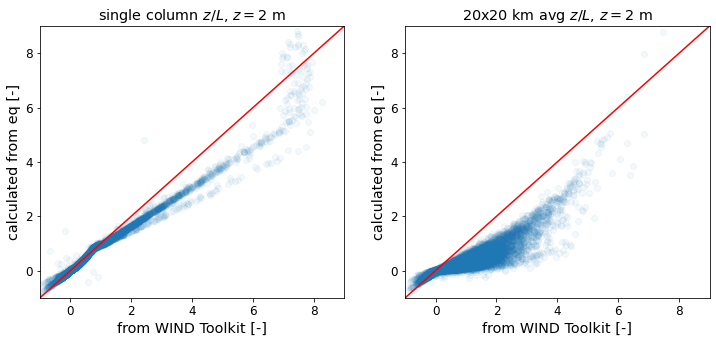

In [40]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set_title(r'single column $z/L$, $z=2$ m', fontsize='x-large')
ax[1].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for i, df in enumerate([dfsc,df20km]):
    ax[i].scatter(df['zoverL_2m'], df['zoverLeq'], alpha=0.05)
    minmax = (-1, 9)
    ax[i].plot(minmax, minmax, 'r')
    ax[i].set_xlim(minmax);  ax[i].set_ylim(minmax)
    ax[i].tick_params(labelsize='large')
    ax[i].set_xlabel(r'from WIND Toolkit [-]', fontsize='x-large')
    ax[i].set_ylabel(r'calculated from eq [-]', fontsize='x-large')
    
# Equation seems to be underestimating for values over z/L > 1 and z/L<8

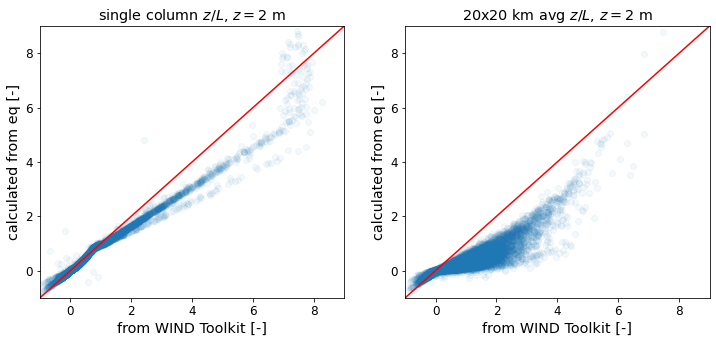

In [41]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].set_title(r'single column $z/L$, $z=2$ m', fontsize='x-large')
ax[1].set_title(r'20x20 km avg $z/L$, $z=2$ m', fontsize='x-large')

for i, df in enumerate([dfsc,df20km]):
    ax[i].scatter(df['zoverL_2m'], df['zoverLeq'], alpha=0.05)
    minmax = (-1, 9)
    ax[i].plot(minmax, minmax, 'r')
    ax[i].set_xlim(minmax);  ax[i].set_ylim(minmax)
    ax[i].tick_params(labelsize='large')
    ax[i].set_xlabel(r'from WIND Toolkit [-]', fontsize='x-large')
    ax[i].set_ylabel(r'calculated from eq [-]', fontsize='x-large')
    
# Equation seems to be underestimating for values over z/L > 1 and z/L<8

### 4.6. Classify Stability

Using classification from "On the extension of the wind profile over homogeneous terrain beyond the surface boundary layer" by Gryning et al (BLM 2007).

In [42]:
Lgry = np.array([-50, -100, -200, -500, 500, 200, 50, 10])

# modifying so it's symmetric (following Eliot's early notebook)
Lranges = np.array([-0.5,-50, -200, -500, 500, 200, 50, 0.5])
zoverL_ranges = 2.0 / Lranges
zoverL_range_names = ['VU','U','NU','N','NS','S','VS']

In [43]:
for i, df in enumerate([dfold,dfsc,df20km]):
    zoverL = df['zoverL_2m'].xs(2,level='height')
    inrange = (zoverL >= zoverL_ranges[0]) & (zoverL <= zoverL_ranges[-1])
    Noutliers = np.count_nonzero(~inrange)
    print(f'Dataframe {i}: {Noutliers} outliers out of {len(zoverL)} ({100*Noutliers/len(zoverL)}%)')

Dataframe 0: 0 outliers out of 26304 (0.0%)
Dataframe 1: 379 outliers out of 17520 (2.16324200913242%)
Dataframe 2: 122 outliers out of 17520 (0.6963470319634704%)


In [44]:
# Set stability classification
for df in dfold,dfsc,df20km:
    df['stability'] = pd.cut(df['zoverL_2m'], bins=zoverL_ranges, labels=zoverL_range_names)

### 4.7. Add season/month information

In [45]:
# Add season information
# 0: winter; 1: spring; 2: summer; 3: fall
season_names = ['winter','spring','summer','fall']

dfsc['season']   = ((dfsc.index.levels[0].month%12)//3).repeat(len(heights_u))
df20km['season'] = ((df20km.index.levels[0].month%12)//3).repeat(len(heights_u))
dfold['season']  = ((dfold.index.levels[0].month%12)//3).repeat(len(heights_oldWTK)+1)
dfcasp['season']  = (dfcasp.index.month%12)//3

In [46]:
# Add month information (make it easier to access it later)
month_names = ['','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

dfsc['month']   = (dfsc.index.levels[0].month%12).repeat(len(heights_u))
df20km['month'] = (df20km.index.levels[0].month%12).repeat(len(heights_u))

# - Save DataFrames for further analysis

In [52]:
dfsc.reset_index().to_feather(os.path.join('data','dfsc.ftr'))
df20km.reset_index().to_feather(os.path.join('data','df20km.ftr'))
dfold.reset_index().to_feather(os.path.join('data','dfold.ftr'))
dfcasp.reset_index().to_feather(os.path.join('data','dfcasp.ftr'))